In [76]:
options(repr.plot.width=8, repr.plot.height=5, jupyter.plot_mimetypes='image/svg+xml')
source('common.r') 
out <- function(obj) write(obj, stdout())

In [22]:
#d.old <- data.retwis(where="(name like '%v0.30%' and nclients = 4)")
d.old <- db.csv("data/retwis-tput-vs-lat.csv")
out("rows: " + nrow(d.old))

rows: 359


In [23]:
sql("SELECT * FROM `d.old` WHERE phasing = 'on' and nthreads = 96")

,X,name,nclients,nthreads,cc,rate,scale,mix,workload,alpha,phasing,async,cc_ph,timeout_scaling,throughput,op_timeouts,avg_latency_ms,txn_failed,total_time
1,41,v0.30-sampa,4,96,r/w locks,50,16,geom_repost,post-heavy,-1,on,0,r/w locks + phasing,500,10033.89,4570,14.51441,508,60.66
2,42,v0.30-sampa,4,96,boosting,50,16,geom_repost,post-heavy,-1,on,0,boosting + phasing,500,27047.2,274,13.77004,12,60.3928
3,44,v0.30-sampa,4,96,r/w locks,50,16,2read2heavy,read-heavy,-1,on,0,r/w locks + phasing,500,81347.2,3466,2.531548,324,60.6471
4,45,v0.30-sampa,4,96,boosting,50,16,2read2heavy,read-heavy,-1,on,0,boosting + phasing,500,74332.48,77,5.080162,0,60.1886
5,47,v0.30-sampa,4,96,boosting + combining,50,16,geom_repost,post-heavy,-1,on,0,boosting + combining + phasing,500,36990.46,1287,10.29971,0,60.0769
6,48,v0.30-sampa,4,96,boosting + combining,50,16,2read2heavy,read-heavy,-1,on,0,boosting + combining + phasing,500,74073.53,912,5.081054,0,60.6135
7,89,v0.30-sampa,4,96,r/w locks,50,16,geom_repost,post-heavy,-1,on,0,r/w locks + phasing,500,9937.556,4617,13.86323,516,60.662
8,90,v0.30-sampa,4,96,boosting,50,16,geom_repost,post-heavy,-1,on,0,boosting + phasing,500,39838.25,858,7.723326,140,45.7012
9,92,v0.30-sampa,4,96,r/w locks,50,16,2read2heavy,read-heavy,-1,on,0,r/w locks + phasing,500,78477.72,3398,2.706078,300,60.646
10,93,v0.30-sampa,4,96,boosting,50,16,2read2heavy,read-heavy,-1,on,0,boosting + phasing,500,76332.6,56,4.95437,0,60.1079


# New results

In [77]:
d <- data.retwis.socc(where="(name like 'v6.1') and shards = 4 and nclients = 4")
out("rows: " + nrow(d))

modes <- c(RW+PH, COMM, COMM+PH, COMB+PH, NOTXN, REDIS)

d <- subset(d, cc_ph %in% modes)
d$cc_ph <- factor(d$cc_ph, levels = rev(modes))

d$x <- d$threads * num(d$nclients)
d$label <- d$threads * num(d$nclients) + "x" + d$rate
d$facet <- with(d, workload) # + "\n" + timeout_scaling)

s <- subset(d, async == 0 
            & (txn_failed < 10 | is.na(txn_failed))
            & total_time > 60 & total_time < 65 
            & (phasing == 'on' | disable_txns == 1 | cc_ph == REDIS)
#             & rate == 5
#             & (name == 'none' | ccmode == 'redis')
           )
out("rows: " + nrow(s))

The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: rw#0#off#0, simple#0#off#0, simple#1#off#0, better#0#off#0, better#1#off#0, better#0#on#0, better#1#on#0, redis#0#NA#0
The following `from` values were not present in `x`: simple:1


rows: 452
rows: 367


In [26]:
#sql("SELECT DISTINCT ccmode, nclients, threads, mix, rate, alpha, scale FROM d")

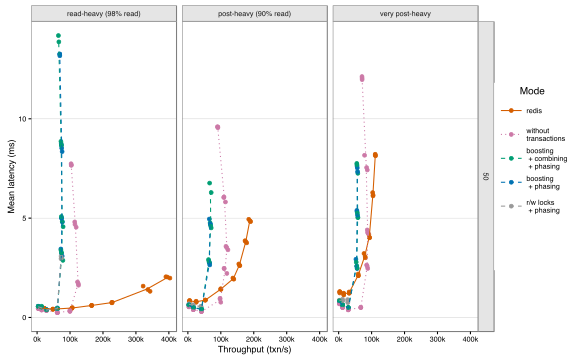

In [27]:
ggplot(s, aes(
    x = throughput,
    y = avg_latency_ms,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
))+
  xlab('Throughput (txn/s)')+ylab('Mean latency (ms)')+
  geom_point()+
  # geom_text(aes(label=label), size=1.7)+
  # scale_x_continuous(labels=si.labels())+
  scale_x_continuous(labels = function(x){ x/1000+'k' })+
  # geom_point()+
  geom_mean_path(s, throughput, avg_latency_ms, .(x,facet,cc_ph, rate))+
  expand_limits(y=0)+
#   facet_wrap(~facet, scales="free")+
  facet_grid(rate~facet)+
  # cc_scales()+phasing.linetype()+
  cc_ph_scales()+
  # coord_cartesian(ylim=c(0,100))+
  my_theme() #+theme(legend.position='bottom')

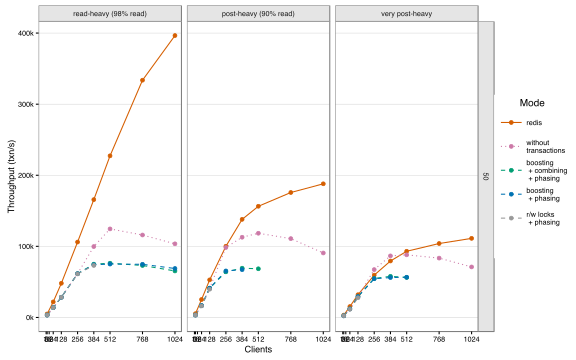

In [28]:
ggplot(subset(s), aes(
    x = x,
    y = throughput,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
  ))+
  xlab('Clients')+ylab('Throughput (txn/s)')+
  stat_summary(geom='line', fun.y=mean)+
  stat_summary(geom='point', fun.y=mean)+  
  #scale_x_continuous(trans=log2_trans(), breaks=c(8,16,32,64,128,256,384))+
  scale_x_continuous(breaks=c(8,16,32,64,128,256,384,512,768,1024))+
  scale_y_continuous(labels = function(x){ x/1000+'k' })+
                     #breaks=c(10000,20000,50000,75000,100000,125000,150000,200000,250000,300000))+
  expand_limits(x=0, y=0)+
#   facet_wrap(~facet)+
facet_grid(rate~facet)+
  cc_ph_scales(guide = guide_legend(nrow = 6))+
  my_theme()

Warning message:
In grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, : font family 'Lato' not found in PostScript font databaseWarning message:
In grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, : font family 'Lato' not found in PostScript font databaseWarning message:
In grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, : font family 'Lato' not found in PostScript font databaseWarning message:
In grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, : font family 'Lato' not found in PostScript font database

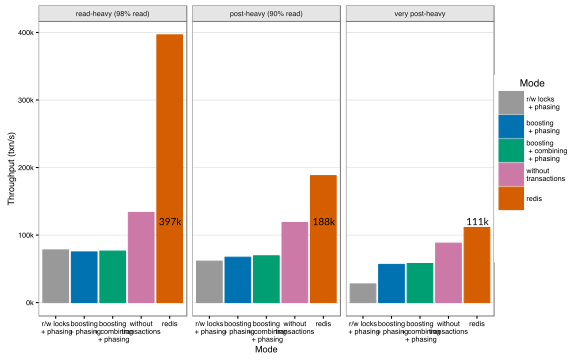

In [80]:
s.mean <- ddply(s, .(x,rate,x,facet,mix,cc_ph), summarize, throughput=mean(throughput), latency=mean(avg_latency_ms), reads=mean(server_ops_read), writes=mean(server_ops_write))
s.mean$cc_ph <- factor(s.mean$cc_ph, levels = rev(levels(s.mean$cc_ph)))

s.mean$read_fraction <- with(s.mean, reads/(reads+writes))

ggplot(s.mean, aes(
    x = cc_ph, color = cc_ph, fill = cc_ph,
    y = throughput
))+
xlab('Mode')+ylab('Throughput (txn/s)')+
stat_summary(geom='bar', fun.y=max)+
#stat_summary(geom='text', aes(label = read_fraction), fun.y=max)+
geom_text(aes(label=label), data=s.redis, color='black', size=3.5, family='Lato', hjust=.48)+
scale_y_continuous(labels=function(x){ x/1000+'k' })+
expand_limits(y=0)+
facet_wrap(~facet)+
cc_ph_scales()+
my_theme()

In [79]:
cap <- 120000
s.redis <- ddply(subset(s.mean, cc_ph == REDIS), .(cc_ph,facet), summarize, tput=max(throughput), throughput=cap)
s.redis$label <- round(s.redis$tput/1000)+'k'

In [68]:
s.redis

,cc_ph,facet,tput,throughput,label
1,redis,read-heavy (98% read),396515.6,120000,397k
2,redis,post-heavy (90% read),187975.4,120000,188k
3,redis,very post-heavy,111243.3,120000,111k


In [51]:
sql("SELECT x, rate, facet, cc_ph, retwis_newuser_fraction, retwis_follow_fraction, retwis_post_fraction, retwis_repost_fraction, retwis_timeline_fraction FROM `s` WHERE facet like 'very%'")

Warning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generated

,x,rate,facet,cc_ph,retwis_newuser_fraction,retwis_follow_fraction,retwis_post_fraction,retwis_repost_fraction,retwis_timeline_fraction
1,16,50,very post-heavy,redis,0.00537333754771572,0.0350604196552311,0.0805028082374967,0.0964283109241654,0.782635123635391
2,64,50,very post-heavy,redis,0.00439789274114594,0.0293710857977591,0.068066325817029,0.0869373779442312,0.811227317699835
3,128,50,very post-heavy,redis,0.00423925250326621,0.0279022145755913,0.0647440458335089,0.084120652596976,0.818993834490658
4,256,50,very post-heavy,redis,0.00413883289412556,0.0269216057136277,0.0625060388311735,0.0822300195757398,0.824203502985333
5,384,50,very post-heavy,redis,0.00404704839546777,0.0263621855616397,0.0615367120939102,0.0812889129923472,0.826765140956635
6,512,50,very post-heavy,redis,0.00400195078370142,0.0262745134124745,0.0610774315573561,0.0812712216741104,0.827374882572358
7,768,50,very post-heavy,redis,0.00397122778962601,0.0261660208829578,0.0608711315681067,0.0809735246413734,0.828018095117936
8,1024,50,very post-heavy,redis,0.00393347468670973,0.0259719218658646,0.0605948112509774,0.0810159128211269,0.828483879375321
9,16,50,very post-heavy,redis,0.00536081464799765,0.0349309703319299,0.0804856555370606,0.0961030059727798,0.783119553510232
10,64,50,very post-heavy,redis,0.00442431650317067,0.0295598666959183,0.0683966945602323,0.0870185225812518,0.810600599659427


[1]   258752  1252280  2634932  4997740  6828616  7803692  8605124  9433596
  [9]   244376  1123648  2505616  5592192  8825148 12155676 17285096 21316128
 [17]   164516   772188  1613492  3022108  4115592  4781668  5262856  5678440
 [25]   260616  1268520  2640232  4979184  6772180  7626880  8678756  9367148
 [33]   248220  1120580  2523528  5593248  8832512 12142700 18479576 21046540
 [41]   163408   765768  1619060  2998580  3983220  4758780  5366008  5697948
 [49]   257704  1250948  2634440  4950788  6865244  7794724  8823468  9219276
 [57]   248760  1136244  2507248  5677784  8852972 12212980 18076496 21713144
 [65]   164204   777444  1609576  3031316  4076760  4648208  5343752  5651260
 [73]   112852   114472   113512   591160   609076   604948  1544040  1601880
 [81]  1591048  2628216  3995860  2759092  4524548  5047216  4525192  3652064
 [89]   109484   109380   109208   462552   465052   462508   988436   976104
 [97]   977992  2237756  2239196  2261148  2709844  2836600  3832716  2866128
[105]  4913236  2765256  4432452  2491196  3933880    85508    85756    86536
[113]   467800   492992   490928  1203372  1264496  1268948  2445500  3034060
[121]  2509408  3864824  2507728  3999900  3957328  3214016   113580   611044
[129]  1596896  2637472  2714924   460328   975160  2226352  2922560  2838672
[137]  2666264  2387388    86100   491804  1265656  2463556  2634260  2479004
[145]   115000   113772   114308   586680   609244   604688  1523848  1590332
[153]  1590160  2670132  4006080  2616432  4909216  4777064  4477684  3709508
[161]   109712   110292   109144   465028   463540   464656   986508   979696
[169]   988600  2233788  2227072  2212732  2705860  2747668  3795828  2744696
[177]  4784460  2812092  4445660  2486924  3945540    84836    86044    86516
[185]   474884   489776   494068  1172312  1270916  1263696  2503636  3036792
[193]  2487504  3941952  2543724  4074916  3861076  3209352   113360   606496
[201]  1592504  2504692  2854412  2651236   109316   462620   979252  2230756
[209]  2751436  2944572  2702120    86016   491900  1265504  2508460  2619768
[217]  2628244   114708   114376   114188   593080   603868   602232  1531820
[225]  1589988  1591840  2579872  4090584  2730152  4551704  4885948  4711804
[233]  3707452   109920   109384   108764   463076   461532   470092   968132
[241]   981680   965852  2207908  2240888  2252792  2733508  2678444  3793904
[249]  2752412  4897404  2719320  4624740  2497592  3958504    85908    86248
[257]    86312   474044   492612   495264  1209132  1274056  1268564  2334372
[265]  3033420  2578200  4025896  2588172  3949968  3564724  3197900   114768
[273]   600948  1586080  2554020  2811484  2861864   109100   465572   988940
[281]  2252224  2683132  2723960  2724628  2330788    85544   492316  1266044
[289]  2374296  2546052  2498872

In [48]:
colnames(s)

[1] "id"                           "op_retries"                  
  [3] "combined_adds"                "server_set_add_exists"       
  [5] "phase_count_total"            "retwis_post_success"         
  [7] "server_phase_duration_count"  "missing_items"               
  [9] "phase_duration_max"           "prepares_possible"           
 [11] "txn_failed"                   "combinable_ops"              
 [13] "server_denied_reset"          "server_fairness_rejects"     
 [15] "retwis_repost_latency"        "cc_check_count"              
 [17] "server_phase_count_total"     "retwis_repost_count"         
 [19] "abort_retries"                "prepare_time"                
 [21] "prepare_retries"              "retwis_follow_success"       
 [23] "server_phase_duration_total"  "total_time"                  
 [25] "server_load_time"             "retwis_timeline_success"     
 [27] "retwis_timeline_latency"      "server_ops_read"             
 [29] "phase_count_count"            "retwis_post_failed"          
 [31] "phase_duration_mean"          "op_timeouts"                 
 [33] "set_add_exists"               "retwis_timeline_retries"     
 [35] "ops_denied"                   "better_saves"                
 [37] "combined_ops"                 "retwis_newuser_count"        
 [39] "retwis_follow_count"          "server_phase_duration_mean"  
 [41] "phase_duration_total"         "phase_duration_count"        
 [43] "abort_failures"               "server_cc_check_set_failed"  
 [45] "fairness_rejects"             "server_ops_commute"          
 [47] "retwis_repost_failed"         "server_acquire_retries"      
 [49] "ops_read"                     "server_ops_write"            
 [51] "cc_check_set_success"         "combined_reads"              
 [53] "retwis_repost_retries"        "server_nwaiters_hist"        
 [55] "retwis_timeline_count"        "server_better_saves"         
 [57] "server_atomic_retries"        "server_op_todos"             
 [59] "atomic_retries"               "retwis_repost_success"       
 [61] "retwis_timeline_failed"       "combined_topk_adds"          
 [63] "server_phase_duration_max"    "server_phase_count_count"    
 [65] "cc_check_failed"              "retwis_newuser_success"      
 [67] "retwis_follow_latency"        "retwis_newuser_failed"       
 [69] "commit_failures"              "server_phase_count_mean"     
 [71] "retwis_post_retries"          "server_ops_denied"           
 [73] "server_cc_check_success"      "cc_check_set_count"          
 [75] "server_efficient_add_count"   "server_efficient_add_success"
 [77] "txn_count"                    "cc_check_success"            
 [79] "efficient_add_success"        "server_missing_items"        
 [81] "efficient_add_count"          "retwis_follow_retries"       
 [83] "server_cc_check_set_count"    "server_cc_check_count"       
 [85] "op_count"                     "server_handle_time_total"    
 [87] "server_acquire_first_success" "prepares_skipped"            
 [89] "commit_retries"               "missing_records"             
 [91] "retwis_newuser_latency"       "retwis_post_count"           
 [93] "server_cc_check_set_success"  "phase_count_max"             
 [95] "retwis_follow_failed"         "cc_check_set_failed"         
 [97] "ops_commute"                  "phase_count_mean"            
 [99] "server_handle_time_mean"      "server_prepares_out_of_order"
[101] "server_asyncs_prepared"       "denied_reset"                
[103] "txn_time"                     "retwis_newuser_retries"      
[105] "efficient_add_failed"         "ops_write"                   
[107] "server_handle_time_count"     "prepare_timeouts"            
[109] "shards"                       "server_cc_check_failed"      
[111] "server_handle_time_max"       "server_acquire_attempts"     
[113] "prepare_rounds"               "server_phase_count_max"      
[115] "txn_retries"                  "server_acquire_retry_success"
[117] "txns_behind_schedule"         "retwis_post_latency"